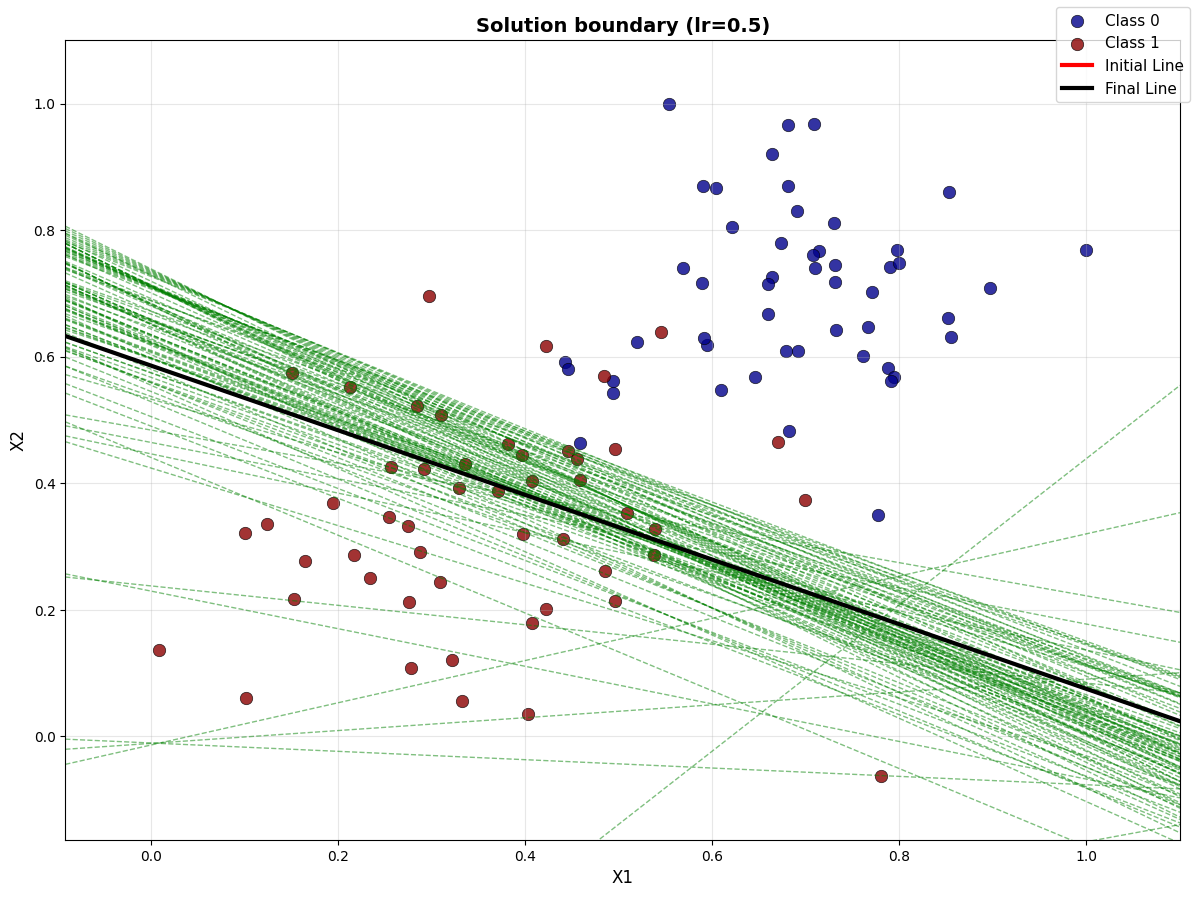

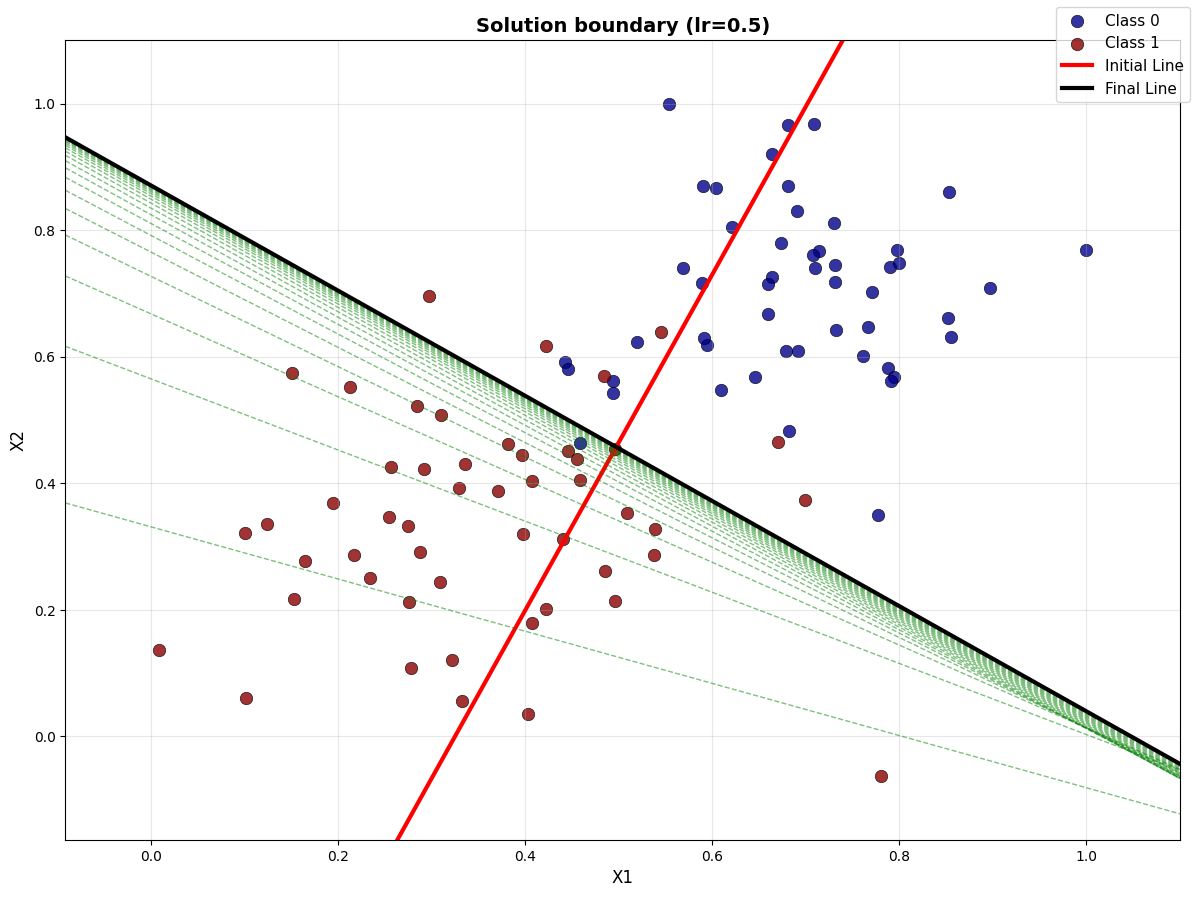

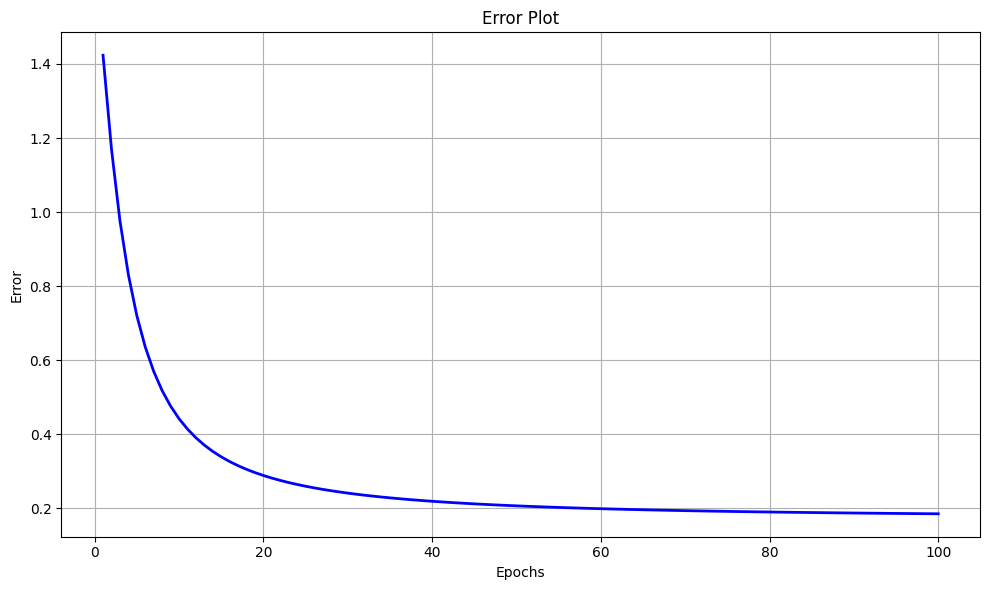

All experiments completed.
Plots saved as PNG files.


In [2]:
# Assignment #5: Perceptron 
# Author: Jake Baartman
# Professor: Bo Shen
# CSCI580 Fall 2025

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Change parameters to experiment with different settings
Part1_LR = 0.5
Part1_Iterations = 100

Part2_LR = 0.5
Part2_Epochs = 100


# Data Loader Class
# - loads CSV data
# - extracts X and y
# - computes plot boundaries

class DataLoader:
    
    def __init__(self, filepath='data.csv'):
        self.filepath = filepath
        self.X = None
        self.y = None
        self.bounds = None
    
    # Load data from file
    def load(self):
        df = pd.read_csv(self.filepath, header=None)
        self.X = df.iloc[:, :-1].values
        self.y = df.iloc[:, -1].values
        self._calculate_bounds()
        return self.X, self.y
    
    # Calculate min/max bounds with margin for cleaner plotting
    def _calculate_bounds(self):
        margin = 0.1
        self.bounds = {
            'x_min': self.X[:, 0].min() - margin,
            'x_max': self.X[:, 0].max() + margin,
            'y_min': self.X[:, 1].min() - margin,
            'y_max': self.X[:, 1].max() + margin
        }


# Visualization Class
# - plots data points
# - draws decision boundaries
# - handles figure saving

class Visualizer:
    
    def __init__(self, X, y, bounds):
        self.X = X
        self.y = y
        self.bounds = bounds
    
    # Create a base figure with labels/grid
    def create_figure(self, title):
        fig, ax = plt.subplots(figsize=(12, 9))
        self._plot_points(ax)
        ax.set_title(title, fontsize=14, fontweight='bold')
        ax.set_xlabel('X1', fontsize=12)
        ax.set_ylabel('X2', fontsize=12)
        ax.grid(True, alpha=0.3)
        ax.set_xlim(self.bounds['x_min'], self.bounds['x_max'])
        ax.set_ylim(self.bounds['y_min'], self.bounds['y_max'])
        return fig, ax
    
    # Plot two classes in red and blue
    def _plot_points(self, ax):
        mask_0 = (self.y == 0)
        mask_1 = (self.y == 1)
        
        ax.scatter(self.X[mask_0, 0], self.X[mask_0, 1],
                  c='darkblue', 
                  marker='o', 
                  s=80, 
                  alpha=0.8,
                  edgecolors='black', 
                  linewidth=0.5, 
                  label='Class 0')
        
        ax.scatter(self.X[mask_1, 0], self.X[mask_1, 1],
                  c='darkred', 
                  marker='o', 
                  s=80, 
                  alpha=0.8,
                  edgecolors='black', 
                  linewidth=0.5, 
                  label='Class 1')
    
    # Draw a line for the decision boundary
    def draw_boundary(self, ax, weights, bias, style='k-', lw=2.5, alpha=1.0, label=None):
        # Case where line is nearly vertical
        if abs(weights[1]) < 1e-6:
            x_coord = -bias / weights[0]
            ax.plot([x_coord, x_coord], 
                   [self.bounds['y_min'], self.bounds['y_max']],
                   style, linewidth=lw, alpha=alpha, label=label)
        else:
            # Normal case compute y from slope-intercept form
            x_range = np.linspace(self.bounds['x_min'], self.bounds['x_max'], 200)
            y_range = -(weights[0] * x_range + bias) / weights[1]
            ax.plot(x_range, y_range, style, linewidth=lw, alpha=alpha, label=label)
    
    # Save figure and show it
    def save_and_show(self, fig, filename):
        fig.legend(fontsize=11)
        plt.tight_layout()
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        plt.show()


# Binary Perceptron 

class BinaryPerceptron:
    
    def __init__(self, learning_rate=0.1, max_iterations=100):
        self.lr = learning_rate
        self.max_iterations = max_iterations
        self.weights = None
        self.bias = None
        self.history = []   # store weight updates for plotting
    
    # Random initialization of weights and bias
    def initialize_weights(self, n_features, seed=0):
        np.random.seed(seed)
        self.weights = np.random.randn(n_features)
        self.bias = np.random.randn()
        self.history.append((self.weights.copy(), self.bias))
    
    # Step activation function
    def activation(self, z):
        return 1 if z >= 0 else 0
    
    # Training loop using perceptron update rule
    def train(self, X, y):
        for iteration in range(self.max_iterations):
            errors = 0
            
            # Iterate over each training sample
            for sample, label in zip(X, y):
                z = np.dot(self.weights, sample) + self.bias
                prediction = self.activation(z)
                
                # Incorrect classification update rule
                if prediction != label:
                    errors += 1
                    delta = self.lr if prediction == 0 else -self.lr
                    self.bias += delta
                    self.weights += delta * sample
            
            # Log updated weights for plotting
            self.history.append((self.weights.copy(), self.bias))
            
            # Stop early if no errors 
            if errors == 0:
                print(f"Converged at iteration {iteration + 1}")
                return iteration + 1
        
        return self.max_iterations


# Gradient Descent Perceptron 

class GradientDescent:
    
    def __init__(self, learning_rate=0.1, max_epochs=100):
        self.lr = learning_rate
        self.max_epochs = max_epochs
        self.weights = None
        self.bias = None
        self.history = []       # store states for boundary plotting
        self.loss_values = []   # store loss curve
    
    # Random initialization
    def initialize_weights(self, n_features, seed=1):
        np.random.seed(seed)
        self.weights = np.random.randn(n_features)
        self.bias = np.random.randn()
        self.history.append((self.weights.copy(), self.bias))
    
    # Sigmoid activation
    def activation(self, z):
        return 1.0 / (1.0 + np.exp(-np.clip(z, -500, 500)))
    
    # Binary cross-entropy loss
    def compute_loss(self, y_true, y_pred):
        epsilon = 1e-12
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    
    # Gradient descent training loop
    def train(self, X, y):
        for epoch in range(1, self.max_epochs + 1):
            
            # Update for each sample
            for sample, label in zip(X, y):
                z = np.dot(self.weights, sample) + self.bias
                prediction = self.activation(z)
                error = label - prediction
                
                self.bias += self.lr * error
                self.weights += self.lr * error * sample
            
            # Save boundary state
            self.history.append((self.weights.copy(), self.bias))
            
            # Compute loss for plotting
            z_all = X @ self.weights + self.bias
            predictions_all = self.activation(z_all)
            loss = self.compute_loss(y, predictions_all)
            self.loss_values.append(loss)
            
            # Convergence condition
            if loss < 0.01:
                print(f"Converged at epoch {epoch}")
                return epoch
        
        return self.max_epochs


# Run Part 1 

def run_part1(X, y, bounds, lr, max_iter):
    model = BinaryPerceptron(learning_rate=lr, max_iterations=max_iter)
    model.initialize_weights(X.shape[1])
    
    viz = Visualizer(X, y, bounds)
    fig, ax = viz.create_figure(f"Solution boundary (lr={lr})")
    
    # Draw initial boundary in red
    viz.draw_boundary(ax, model.weights, model.bias, 'r-', lw=3, label='Initial Line')
    
    # Train model
    model.train(X, y)
    
    # Draw intermediate green boundaries
    for w, b in model.history:
        viz.draw_boundary(ax, w, b, 'g--', lw=1, alpha=0.5)
    
    # Draw final boundary in black
    viz.draw_boundary(ax, model.weights, model.bias, 'k-', lw=3, label='Final Line')
    
    viz.save_and_show(fig, f'Part1_LR_{lr}.png')


# Run Part 2 

def run_part2(X, y, bounds, lr, max_epochs):
    model = GradientDescent(learning_rate=lr, max_epochs=max_epochs)
    model.initialize_weights(X.shape[1])
    
    viz = Visualizer(X, y, bounds)
    fig, ax = viz.create_figure(f"Solution boundary (lr={lr})")
    
    viz.draw_boundary(ax, model.weights, model.bias, 'r-', lw=3, label='Initial Line')
    
    # Train model
    model.train(X, y)
    
    # Plot intermediate boundaries every 5 updates
    for i in range(5, len(model.history), 5):
        w, b = model.history[i]
        viz.draw_boundary(ax, w, b, 'g--', lw=1, alpha=0.5)
    
    # Final boundary in black
    viz.draw_boundary(ax, model.weights, model.bias, 'k-', lw=3, label='Final Line')
    
    viz.save_and_show(fig, f'Part2_LR_{lr}.png')
    
    # Loss curve
    fig_loss, ax_loss = plt.subplots(figsize=(10, 6))
    ax_loss.plot(range(1, len(model.loss_values) + 1), model.loss_values, 'b-', linewidth=2)
    ax_loss.set_xlabel('Epochs')
    ax_loss.set_ylabel('Error')
    ax_loss.set_title('Error Plot')
    ax_loss.grid(True)
    plt.tight_layout()
    plt.savefig(f'part2_loss_lr_{lr}.png')
    plt.show()


# Main Function

def main():
    loader = DataLoader('data.csv')
    X, y = loader.load()
        
    run_part1(X, y, loader.bounds, Part1_LR, Part1_Iterations)
    run_part2(X, y, loader.bounds, Part2_LR, Part2_Epochs)

    print("All experiments completed.")
    print("Plots saved as PNG files.")

if __name__ == "__main__":
    main()
